# To calibration the polarizer and analyzer angle

In [1]:
from cProfile import label
from cmath import exp, pi
from numpy import tan, sin, sqrt,cos,arctan,arcsin
from re import A
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import numpy as npy
from scipy.signal import savgol_filter
from matplotlib.pyplot import MultipleLocator
from iminuit import Minuit
import iminuit
from iminuit.cost import LeastSquares
# import latex
# plt.style.reload_library()
plt.style.use(['science'])
# plt.style.use(['science','ieee'])
# plt.style.use(['science','no-latex'])

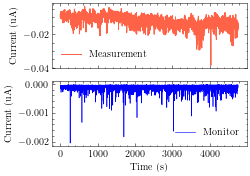

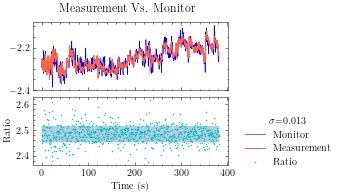

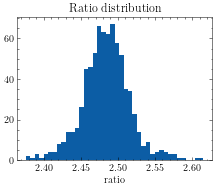

In [2]:
def currentDark(filename,type):
    inputfile=open(filename,'r')
    dark=[]
    time=[]
    i=0
    while(1):
        try:
            temp=next(inputfile).split()
            if(temp[4]!=type):
                continue
            if(float(temp[2])>0):
                continue
            dark.append(1e6*float(temp[2]))
            time.append(i*0.5)
            i=i+1
        except StopIteration:
            break
    # dark=npy.mean(npy.array(dark))
    return npy.array(dark),npy.array(time)
dark1,time1 = currentDark('dataMirror/measurement_dark.txt','dark')
dark2,time2 = currentDark('dataMirror/monitor_dark.txt','dark')
dark_measurement=npy.mean(dark1)
dark_monitor=npy.mean(dark2)
fig,ax=plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)')
ax[0].set_ylabel('Current (uA)')
ax[1].set_ylabel('Current (uA)')
ax[0].plot(time1,dark1,label='Measurement',linewidth=1,color='tomato')
ax[1].plot(time2,dark2,label='Monitor',linestyle="-",color='b',linewidth=0.6)
ax[0].legend()
ax[1].legend()
fig.patch.set_facecolor('white')
# plt.close()
# fig.savefig("cali_figure/dark&ratio/darkcurrent.png",dpi=1000)

ratio1,time1 =  currentDark('dataMirror/measurement_dark.txt','ratio')
ratio2,time2 = currentDark('dataMirror/monitor_dark.txt','ratio')
ratio1=ratio1[:-1]
time1=time1[:-1]


fig,ax=plt.subplots(2,1,sharex=True)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Ratio')
# ax1=ax[0].twinx()
ax[0].plot(time2,ratio2*npy.mean(ratio1/ratio2),label='Monitor',color='b',linewidth=0.6)
ax[0].plot(time1,ratio1,label='Measurement',linewidth=1,color='tomato')
ax[1].plot(time1,ratio1/ratio2,label='Ratio',color='c',marker='.',markersize=1,linestyle='')
ax[1].fill_between(time1,npy.mean(ratio1/ratio2)+npy.std(ratio1/ratio2),npy.mean(ratio1/ratio2)-npy.std(ratio1/ratio2),alpha=0.3)
ax[1].fill
fig.suptitle('Measurement Vs. Monitor')
fig.subplots_adjust(hspace=0.1)
fig.patch.set_facecolor('white')
fig.legend(title='$\sigma$='+str(round(npy.std(ratio1/ratio2)/npy.mean(ratio1/ratio2),3)),bbox_to_anchor=(0.95, 0.4), loc=2, borderaxespad=0)
# fig.savefig('cali_figure/dark&ratio/ratio.png',dpi=1000)
# plt.close()

fig,ax=plt.subplots()
plt.hist(ratio1/ratio2,bins=40)
plt.title('Ratio distribution')
plt.xlabel('ratio')
fig.patch.set_facecolor('white')
# plt.savefig('cali_figure/dark&ratio/ratiohist.png',dpi=1000)
# plt.close()

## Define class and fit function

In [48]:
def calculate_index(phi,delta):
    phi=float(phi*pi/180)
    delta=float(delta*pi/180)
    anglei=65/180*pi
    rho=tan(phi)*exp(delta*1j)
    # n1=1.#for air
    n1=1
    # print('rho',rho)
    epsilon= (n1**2) * (sin(anglei)**2) * ( 1+(tan(anglei)**2)*((1-rho)/(1+rho))**2) 
    ep_re=epsilon.real
    ep_im=epsilon.imag
    n2=(1./sqrt(2.) * sqrt( sqrt(ep_re**2+ep_im**2) +ep_re)).real
    k2=(1./sqrt(2.) * sqrt( sqrt(ep_re**2+ep_im**2) -ep_re)).real
    return n2,k2
def calculate_rho(n2,anglei1):
    anglei1=anglei1/180*pi
    n1=1
    anglei2=arcsin(n1*sin(anglei1)/n2 )
    rp=tan(anglei1-anglei2)/tan(anglei1+anglei2)
    rs=sin(anglei2-anglei1)/sin(anglei2+anglei1)
    return rp/rs
def intensityFun1(t,scale,a,b,w): #define fit function
    phi=w*t
    # return a0+a1*npy.cos(2*phi)
    return (1+a*npy.cos(2*phi)+ b*npy.sin(2*phi))*scale

def intensityFun(phi,scale,a,b): #define fit function
    # phi=w*phi
    # return a0+a1*npy.cos(2*phi)
    return (1+a*npy.cos(2*phi)+ b*npy.sin(2*phi))*scale
def intensityFun2(phi,scale,a,b,w): #define fit function
    # phi=w*phi
    # return a0+a1*npy.cos(2*phi)
    phi=phi*w
    return (1+a*npy.cos(2*phi)+ b*npy.sin(2*phi))*scale

class dataVar:
    def __init__(self,angleP):
        self.angleP=angleP
        self.current=[]
        self.time=[]
        self.angleA=[]

def reader(filename,angleP,use):
    data=dataVar(angleP)
    inputfile=open(filename,'r')
    i=0
    while(1):
        try:
            temp=next(inputfile).split()
            if(float(temp[4])!=(angleP)):
                continue
            data.time.append(i*0.5)
            if(use=='measurement'):
                data.current.append(1e6*float(temp[2])-dark_measurement)
            elif(use=='monitor'):
                data.current.append(1e6*float(temp[2])-dark_monitor)
            i=i+1
        except StopIteration:
            break
    return data

## Calculate a series of $\alpha$ and $\beta$ for future fit

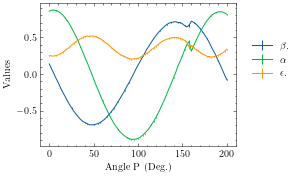

In [60]:
# a=[3,0,3,3,0,2,1,1,1,2,2]  # the delay time of two Ammeters 
# starttime=[ int(1*i+1) for i in range(37) ]
w0=10/360*pi   # this is the estimated angular velocity
alpha=[]
alpha_err=[]
beta=[]
beta_err=[]
epsilon=[]
epsilon_err=[]
angleP_radian=[]
# angleP=npy.array([(5*i-90)/360*pi for i in range(37)])
angleA=npy.array([(i+1)*10/180*pi for i in range(36)])

angleP=[]
# angleA=angleA[3:-3]

for ip in range(81):
    signal_cut=npy.array([])
    time_cut=npy.array([])
    angleP_temp=ip*2.5    #in degree
    window=10
    angleP.append(angleP_temp)
    angleP_radian.append(angleP_temp/180*pi)
    data_measurement=reader('measurement.txt',angleP_temp,'measurement')
    data_monitor=reader('monitor.txt',angleP_temp,'monitor')
    # print(len(data_measurement.current))
    # print(len(data_monitor.current))
    length=-len(data_measurement.current)+len(data_monitor.current)
    # length1=720
    # print(length)
    

    data_monitor.time=data_monitor.time[length:]
    data_monitor.current=data_monitor.current[length:]
    # data_measurement.time=data_measurement.time[0:length]
    # data_measurement.current=data_measurement.current[0+b[ip]:length+b[ip]]
    # data_measurement.current=savgol_filter(npy.array(data_measurement.current),window,3)
    # data_monitor.current=savgol_filter(npy.array(data_monitor.current),window,3)

    signal=npy.array(data_measurement.current)/npy.array(data_monitor.current)
    # for i in range(36):
    #     signal_cut=npy.append(signal_cut,signal[i*16:i*16+16])
    #     time_cut=npy.append(time_cut,data_measurement.time[i*16:i*16+16])
        # if(signal[680+t]>=mean_end):
            # if(ip==10):
                # end_time=680+t-6
            # elif(ip==8):
                # end_time=680+t-9
            # else:
                # end_time=680+t
            # break
        # else:
            # continue
    # end_time = len(signal)
    # signal_cut=npy.array(signal[starttime[ip]:starttime[ip]+length1])
    # signal_err=npy.sqrt(signal_cut)
    # time_cut=npy.array(data_measurement.time[starttime[ip]:starttime[ip]+length1])

    fig,ax=plt.subplots(2,1,sharex=True)
    ax[1].set_xlabel('Time (s)')
    ax[0].set_ylabel('Intensity')
    ax[0].plot(data_measurement.time,signal,label='Quartz class 400nm',linewidth=1,color='c')#,color='blue)
    delaytime=1
    period=12
    correction=1.028
    cut=2
    signal_mean=[]
    for i in range(36):
        run=int(i*period*correction+delaytime)
        stop=int((i+1)*period*correction+delaytime)
        signal_cut=npy.array(signal[run+cut:stop-cut])
        time_cut=npy.array(data_measurement.time[run+cut:stop-cut])
        signalmean=npy.mean(signal_cut)               #this is the signal for fit
        signal_mean.append(signalmean)
        signalmean_list=[signalmean]*(stop-run-2*cut)
        ax[0].plot(time_cut,signal_cut,color='grey')#,color='blue)
        ax[0].plot(time_cut,signalmean_list,linewidth=1.2)#,color='blue)
    ax[1].set_ylabel('Current (uA)')
    ax1=ax[1].twinx()
    ax[1].plot(data_measurement.time,data_measurement.current,label='measurement')
    ax1.plot(data_monitor.time,data_monitor.current,label='monitor',color='orange')
    fig.suptitle(str(round(ip*2.5,1))+' Deg. Intensity Vs. Time')
    fig.subplots_adjust(hspace=0.1)
    fig.patch.set_facecolor('white')
    # ax[0].legend()
    # ax[1].legend()
    # ax1.legend()
    fig.legend(bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
    # plt.close()

    # if ip< 10: fig.savefig('cali_figure/intensity/'+ str(round(ip*2.5,1))+ 'DegIntensityVsTime.png',dpi=1000)
    plt.close()

    # print(signal_mean)
    # print(npy.sqrt(signal_mean))

    # fig.savefig('cali_figure/intensity/'+ str(ip*5/2)+ 'DegIntensityVsTime.png',dpi=1000)
    
    #time_cut and signal_cut ,signal_err is the x y yerr we need to fit.
    # time_cut=time_cut-0.5*(len(time_cut)-1)
    

    # least_squares=LeastSquares(angleA,signal_mean,signal_err,intensityFun)
    # least_squares=LeastSquares(angleA,signal_mean,intensityFun)
    # m=Minuit(least_squares,scale=2,a=0,b=0)
    # m.limits[4]=(-0.3,0.3)
    # m.migrad()
    # m.hesse()
    # para=m.values
    # err=m.errors
    # p0=[0,0,0,w]
    # para,_=curve_fit(intensityFun,time_cut,signal_cut,p0)
    # print(para)
    # print(err)
    signal_mean=npy.array(signal_mean)
    signal_err=npy.sqrt(signal_mean).real
    # print(signal_mean,signal_err)
    # signal_mean=signal_mean[3:-3]
    # signal_err=signal_err[3:-3]

    p0=[2,0,0]
    # p0=[2,0,0,1]
    para,cov=curve_fit(intensityFun,angleA,signal_mean,p0)
    err=[]
    err.append(sqrt(cov[0][0]))
    err.append(sqrt(cov[1][1]))
    err.append(sqrt(cov[2][2]))
    parameters=['Scale','alpha','beta']
    alpha.append(para[1])
    alpha_err.append(err[1])
    beta.append(para[2])
    beta_err.append(err[2])
    epsilon.append(1-para[1]**2-para[2]**2)
    epsilon_err.append(sqrt(4*para[1]**2*err[1]**2+4*para[2]**2*err[2]**2).real)
    signal_fit=intensityFun(angleA,*para)
    ratio_fit=signal_mean/signal_fit
    fig,ax=plt.subplots(2,1,sharex=True)
    # fit_info = [
    #     f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m.fval:.1f} / {len(angleA) - m.nfit}",
    #     ]
    # for p, v, e in zip(m.parameters, m.values, m.errors):
    #     fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$") 
    fit_info = []
    for p, v, e in zip(parameters, para,err):
        fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
    ax[1].set_xlabel('Angle A')
    ax[0].set_ylabel('Intensity')
    ax[0].plot(angleA,signal_mean,label='Ori. signal',linewidth=1,color='orange')#,color='blue)
    ax[0].plot(angleA,signal_fit,label='Fitted signal',linestyle="--",color='k',linewidth=1)#,color='blue)
    ax[1].set_ylabel('Ratio')
    ax[1].plot(angleA,ratio_fit,'.',label='Ori. Vs. Fitted',markersize=1)
    plt.fill_between(angleA,npy.mean(ratio_fit)+npy.std(ratio_fit),npy.mean(ratio_fit)-npy.std(ratio_fit),alpha=0.3)
    ax[1].fill
    fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
    fig.suptitle(str(ip*2.5)+' Deg. Fit Result')
    # ax[0].legend(title="\n".join(fit_info))
    # ax[0].legend()
    # ax[1].legend()
    fig.patch.set_facecolor('white')
    # fig.savefig('cali_figure/fit_result/'+ str(ip*2.5)+ 'DegIntensityVsTime.png',dpi=1000)
    plt.close()
# print(epsilon)
# print(epsilon_err)
fig,ax=plt.subplots()
ax.errorbar(angleP,beta,beta_err,label='$\\beta$.',linewidth=1)#''',color='orange')'''#,color='blue)
ax.errorbar(angleP,alpha,alpha_err,label='$\\alpha$',linewidth=1)#,color='orange')#,color='blue)
ax.errorbar(angleP,epsilon,epsilon_err,label='$\\epsilon$.',linewidth=1)#,color='orange')#,color='blue)
ax.set_xlabel('Angle P (Deg.)')
ax.set_ylabel('Values')
fig.legend(bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
fig.patch.set_facecolor('white')
fig.savefig('cali_figure/alphabeta.png',dpi=1000)
# print(angleP)


## Fit the P and epsilon with angleP epsilon and epsilon_err

In [61]:
def residualFun(P,phi,delta,Ps,As,eta):
    # eta=1
    As_radian=As
    Ps_radian=Ps
    phi_radian=phi
    delta_radian=delta
    a1=( ( tan(phi_radian) )**2-( tan(P-Ps_radian) )**2 )/( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    b1=( 2*tan(phi_radian)*cos(delta_radian)*tan(P-Ps_radian) ) /( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    a = 1/eta * ( a1*cos(2*As_radian)-b1*sin(2*As_radian) )
    b = 1/eta * ( a1*sin(2*As_radian)+b1*cos(2*As_radian) )
    return 1-a**2-b**2

def betaFun(P,phi,delta,Ps,As,eta):
    As_radian=As
    Ps_radian=Ps
    phi_radian=phi
    delta_radian=delta
    a1=( ( tan(phi_radian) )**2-( tan(P-Ps_radian) )**2 )/( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    b1=( 2*tan(phi_radian)*cos(delta_radian)*tan(P-Ps_radian) ) /( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    return  1/eta * ( a1*sin(2*As_radian)+b1*cos(2*As_radian) )

def alphaFun(P,phi,delta,Ps,As,eta):
    As_radian=As
    Ps_radian=Ps
    phi_radian=phi
    delta_radian=delta
    a1=( ( tan(phi_radian) )**2-( tan(P-Ps_radian) )**2 )/( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    b1=( 2*tan(phi_radian)*cos(delta_radian)*tan(P-Ps_radian) ) /( ( tan(phi_radian) )**2+( tan(P-Ps_radian) )**2 )
    return  1/eta * ( a1*cos(2*As_radian)-b1*sin(2*As_radian) )


## Define the fit method

total  <ValueView phi=0.7520020259793498 delta=2.491492235748444 Ps=0.06229909767721363 As=0.021611605317322594 eta=1.1378467254529328>
total err <ErrorView phi=0.0002645809516747915 delta=0.0011933299977907941 Ps=0.0009242511243082521 As=0.0009218391738582323 eta=0.0006699227282255909>


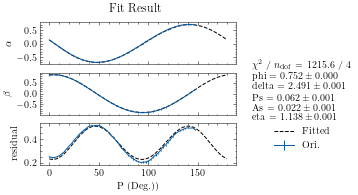

In [62]:
# the remark is double
angleP_radian=angleP_radian[:60]
angleP=angleP[:60]
alpha=alpha[:60]
alpha_err=alpha_err[:60]
beta=beta[:60]
beta_err=beta_err[:60]
epsilon=epsilon[:60]
epsilon_err=epsilon_err[:60]
least_squares_residual=LeastSquares(angleP_radian,epsilon,epsilon_err,residualFun)
least_squares_beta=LeastSquares(angleP_radian,beta,beta_err,betaFun)
least_squares_alpha=LeastSquares(angleP_radian,alpha,alpha_err,alphaFun)
# least_squares_total=least_squares_beta+least_squares_alpha+least_squares_residual
least_squares_total=least_squares_beta+least_squares_alpha
# least_squares_total=least_squares_beta+least_squares_alpha+least_squares_residual
# least_squares_residual=LeastSquares(angleP_radian[18:],epsilon[18:],epsilon_err[18:],residualFun)
# least_squares_beta=LeastSquares(angleP_radian[18:],beta[18:],beta_err[18:],betaFun)
# least_squares_alpha=LeastSquares(angleP_radian[18:],alpha[18:],alpha_err[18:],alphaFun)
phi_quartz=0.8
startAs=0.06
startPs=0.1
startDelta=3
# print("phi",phi_quartz)
# let the beta fit first
m_total=Minuit(least_squares_total,phi=phi_quartz,delta=startDelta,Ps=startPs,As=startAs,eta=1)
# m_total.fixed[4]=True
m_total.limits[2]=(0,1/2*pi)
m_total.limits[3]=(0,1/2*pi)
m_total.migrad()
m_total.hesse()
# m_beta=Minuit(least_squares_beta,phi=phi_quartz,delta=startDelta,Ps=startPs,As=startAs,eta=1)
# # m_beta.limits[0]=(phi_quartz-20,phi_quartz+20)
# # m_beta.limits[1]=(startDelta-10,startDelta+10)
# # m_beta.limits[2]=(0,180)
# # m_beta.limits[3]=(0,180)
# # m_beta.limits[4]=(0,1)
# # m_beta.errors=1
# # m_beta.fixed[4]=True
# m_beta.migrad()
# m_beta.hesse()
# # then lets fit the residual
# m_residual=Minuit(least_squares_residual,phi=phi_quartz,delta=startDelta,Ps=startPs,As=startAs,eta=1)
# # m_residual.limits[0]=(phi_quartz-20,phi_quartz+20)
# # m_residual.limits[1]=(startDelta-10,startDelta+10)
# # m_residual.limits[2]=(0,180)
# # m_residual.limits[3]=(0,180)
# # m_residual.limits[4]=(0,1)
# m_residual.migrad()
# m_residual.hesse()

# m_alpha=Minuit(least_squares_alpha,phi=phi_quartz,delta=startDelta,Ps=startPs,As=startAs,eta=1)
# # m_alpha.limits[0]=(phi_quartz-20,phi_quartz+20)
# # m_alpha.limits[1]=(startDelta-10,startDelta+10)
# # m_alpha.limits[2]=(0,180)
# # m_alpha.limits[3]=(0,180)
# # m_alpha.limits[4]=(0,1)
# m_alpha.migrad()
# m_alpha.hesse()
# m.minos()
angleP_fit=[(i/(2)) for i in range(360)]
angleP_fitRadian=npy.array(angleP_fit)*pi/180
# beta_fit=betaFun(npy.array(angleP_fitRadian),*m_beta.values)
beta_fit=betaFun(npy.array(angleP_fitRadian),*m_total.values)
epsilon_fit=residualFun(npy.array(angleP_fitRadian),*m_total.values)
# epsilon_fit=residualFun(npy.array(angleP_fitRadian),*m_residual.values)
alpha_fit=alphaFun(npy.array(angleP_fitRadian),*m_total.values)
# alpha_fit=alphaFun(npy.array(angleP_fitRadian),*m_alpha.values)


fig,ax=plt.subplots(3,1,sharex=True)
fit_info = [
    f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_total.fval:.1f} / {len(time_cut) - m_total.nfit}",
    ]
for p, v, e in zip(m_total.parameters, m_total.values, m_total.errors):
    fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
ax[2].set_xlabel('P (Deg.))')
ax[0].set_ylabel('$\\alpha$')
ax[1].set_ylabel('$\\beta$')
ax[2].set_ylabel('residual')
ax[0].errorbar(angleP,beta,beta_err,label='Ori.',linewidth=1)#,color='blue)
ax[0].plot(angleP_fit,beta_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
ax[1].plot(angleP_fit,alpha_fit,linestyle="--",color='k',linewidth=1)#,color='blue)
ax[1].errorbar(angleP,alpha,alpha_err,linewidth=1)#,color='blue)
ax[2].plot(angleP_fit,epsilon_fit,linestyle="--",color='k',linewidth=1)#,color='blue)
ax[2].errorbar(angleP,epsilon,epsilon_err,linewidth=1)#,color='blue)
fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
fig.suptitle('Fit Result')
fig.patch.set_facecolor('white')
fig.savefig('cali_figure/AlphaBetaFit.png',dpi=1000)

# fig,ax=plt.subplots()
# fit_info = [
#     f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_beta.fval:.1f} / {len(time_cut) - m_beta.nfit}",
#     ]
# for p, v, e in zip(m_beta.parameters, m_beta.values, m_beta.errors):
#     fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
# ax.set_xlabel('P (Deg.))')
# ax.set_ylabel('$\\beta$')
# # ax.errorbar(angleP,epsilon,epsilon_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
# ax.errorbar(angleP,beta,beta_err,label='Ori.',linewidth=1)#,color='blue)
# ax.plot(angleP_fit,beta_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# # ax.plot(angleP,epsilon_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# # ax.set_ylabel('Ratio')
# # ax.plot(time_cut,ratio_fit,'.',label='Ori. Vs. Fitted',markersize=1)
# # plt.fill_between(time_cut,npy.mean(ratio_fit)+npy.std(ratio_fit),npy.mean(ratio_fit)-npy.std(ratio_fit),alpha=0.3)
# # ax[1].fill
# fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
# fig.suptitle('Beta Fit Result')
# fig.suptitle('Beta Fit Result')
# ax[0].legend(title="\n".join(fit_info))
# ax[0].legend()
# ax[1].legend()
# fig.patch.set_facecolor('white')
# fig.savefig('cali_figure/BetaFit.png',dpi=1000)

# fig,ax=plt.subplots()
# fit_info = [
#     f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_alpha.fval:.1f} / {len(time_cut) - m_alpha.nfit}",
#     ]
# for p, v, e in zip(m_alpha.parameters, m_alpha.values, m_alpha.errors):
#     fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
# ax.set_xlabel('P (Deg.))')
# ax.set_ylabel('$\\alpha$')
# # ax.errorbar(angleP,epsilon,epsilon_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
# ax.errorbar(angleP,alpha,alpha_err,label='Ori.',linewidth=1)#,color='blue)
# ax.plot(angleP_fit,alpha_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# # ax.plot(angleP,epsilon_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# # ax.set_ylabel('Ratio')
# # ax.plot(time_cut,ratio_fit,'.',label='Ori. Vs. Fitted',markersize=1)
# # plt.fill_between(time_cut,npy.mean(ratio_fit)+npy.std(ratio_fit),npy.mean(ratio_fit)-npy.std(ratio_fit),alpha=0.3)
# # ax[1].fill
# fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
# fig.suptitle('Alpha Fit Result')
# # fig.suptitle('Beta Fit Result')
# # ax[0].legend(title="\n".join(fit_info))
# # ax[0].legend()
# # ax[1].legend()
# fig.patch.set_facecolor('white')
# fig.savefig('cali_figure/AlphaFit.png',dpi=1000)

# fig,ax=plt.subplots()
# fit_info = [
#     f"$\\chi^2$ / $n_\\mathrm{{dof}}$ = {m_residual.fval:.1f} / {len(time_cut) - m_residual.nfit}",
#     ]
# for p, v, e in zip(m_residual.parameters, m_residual.values, m_residual.errors):
#     fit_info.append(f"{p} = ${v:.3f} \\pm {e:.3f}$")
# ax.set_xlabel('P (Deg.))')
# ax.set_ylabel('$\\epsilon$')
# ax.errorbar(angleP,epsilon,epsilon_err,label='Ori.',linewidth=1)#,color='blue)
# # ax.errorbar(angleP,beta,beta_err,label='Ori.',linewidth=1,color='orange')#,color='blue)
# # ax.plot(angleP,beta_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# ax.plot(angleP_fit,epsilon_fit,label='Fitted',linestyle="--",color='k',linewidth=1)#,color='blue)
# # ax.set_ylabel('Ratio')
# # ax.plot(time_cut,ratio_fit,'.',label='Ori. Vs. Fitted',markersize=1)
# # plt.fill_between(time_cut,npy.mean(ratio_fit)+npy.std(ratio_fit),npy.mean(ratio_fit)-npy.std(ratio_fit),alpha=0.3)
# # ax[1].fill
# fig.legend(title="\n".join(fit_info),bbox_to_anchor=(0.95, 0.7), loc=2, borderaxespad=0)
# fig.suptitle('Residual Fit Result')
# # fig.suptitle('Beta Fit Result')
# # ax[0].legend(title="\n".join(fit_info))
# # ax[0].legend()
# # ax[1].legend()
# fig.patch.set_facecolor('white')
# fig.savefig('cali_figure/ResidualFit.png',dpi=1000)

# print(m_residual.params)
# print(m_beta.params)
# print(m_alpha.params)
# plt.close()
# print("beta "+str(calculate_index(m_beta.values[0],m_beta.values[1])))
# print("alpha "+str(calculate_index(m_alpha.values[0],m_alpha.values[1])))
# print("residual "+str(calculate_index(m_residual.values[0],m_residual.values[1])))
# print(angleP)
# print("beta ",m_beta.values)
# print("alpha ",m_alpha.values)
# print("residual ",m_residual.values)
print("total ",m_total.values)
print("total err",m_total.errors)
# print("Ps,As,tanPhi,cosDelta,eta",m_total.values[2]/180*pi,m_total.values[3]/180*pi,tan(m_total.values[0]/180*pi),cos(m_total.values[1]/180*pi),m_total.values[4])